In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import json
import os
import pickle
import pandas as pd



def find_closest_index(time_arr, time_sampled):
    closest_indices = []
    for sample in time_sampled:
        closest_index = min(range(len(time_arr)), key=lambda i: abs(time_arr[i] - sample))
        closest_indices.append(closest_index)
    return closest_indices

def cubic_length(t, a, v0, l0, t0):
    """
    Quadratic length function.
    """

    # Only take times <= t0
    t_before = t[t <= t0]

    # Only take times > t0
    t_after = t[t > t0]

    # Compute the length linearly before t0
    l_before = l0 + v0*t_before

    # Compute the length quadratically after t0
    l_after = a*(t_after - t0)**3 + v0*(t_after - t0) + l0

    return np.concatenate((l_before, l_after))

def cubic_lag(t, a, t0):
    """
    Quadratic lag function.
    """

    # Only take times <= t0
    t_before = t[t <= t0]

    # Only take times > t0
    t_after = t[t > t0]

    # Compute the lag linearly before t0
    l_before = np.zeros_like(t_before)

    # Compute the lag quadratically after t0
    l_after =  -abs(a)*(t_after - t0)**3

    return np.concatenate((l_before, l_after))


def cubic_velocity(t, a, v0, t0):
    """
    Quadratic velocity function.
    """

    # Only take times <= t0
    t_before = t[t <= t0]

    # Only take times > t0
    t_after = t[t > t0]

    # Compute the velocity linearly before t0
    v_before = np.ones_like(t_before)*v0

    # Compute the velocity quadratically after t0
    v_after = 3*a*(t_after - t0)**2 + v0

    return np.concatenate((v_before, v_after))

def cubic_acceleration(t, a, t0):
    """
    Quadratic acceleration function.
    """

    # Only take times <= t0
    t_before = t[t <= t0]

    # Only take times > t0
    t_after = t[t > t0]

    # No deceleration before t0
    a_before = np.zeros_like(t_before)

    # Compute the acceleration quadratically after t0
    a_after = 6*a*(t_after - t0)

    return np.concatenate((a_before, a_after))



def length_residual(params, t_time, l_data):
    """
    Residual function for the optimization.
    """
    return np.sum((l_data - cubic_length(t_time, *params))**2)


def lag_residual(params, t_time, l_data):
    """
    Residual function for the optimization.
    """

    return np.sum((l_data - cubic_lag(t_time, *params))**2)

In [7]:
def plot_lagVel_fit(v0, time_array, lag_array_noisy, vel_array_noisy, lag_array=0, velocity_array=0):
    # Set t0 to the middle of the time array
    t0 = np.mean(time_array)

    # fit a line woith the noisty velocity data
    p = np.polyfit(time_array, vel_array_noisy, 1)
    # plot tyhe line
    initial_guess_line_aVal = np.polyval(p, time_array)

    # initial guess of deceleration decel
    decel0 = p[0]

    # p0 = [-2000, -5000, t0]
    # p0 = [-3.77628219e+03,  9.64136440e-07, 7.65056353e-02]
    # p0 = [-19543.839, 0.,   0.268]
    # p0 = [-10168.603,      0.,         0.183]
    # p0 = [-10000,      0.,         t0*3/4]
    p0 = [decel0,        t0]

    # plot the results not in scientific notation
    np.set_printoptions(suppress=True,precision=5)
    print("Initial guess")
    print(p0)


    opt_res = opt.minimize(lag_residual, p0, args=(time_array, lag_array_noisy), method='Nelder-Mead')
    # opt_res = opt.minimize(lag_residual, p0, args=(time_array, lag_array_noisy), method='L-BFGS-B', bounds=[(-10000, 0), (-10000, 10000), (0, 0.5)])
    #opt_res = opt.basinhopping(lag_residual, p0, minimizer_kwargs={"args": (time_array, lag_array_noisy), "method": "L-BFGS-B"}, niter=100)

    print("Optimal parameters")
    print(opt_res.x)

    # sample the fit for the velocity and acceleration
    a_fit, t0_fit = opt_res.x
    velocity_array_fit = cubic_velocity(time_array, a_fit, v0, t0_fit)
    # acceleration_array_fit = cubic_acceleration(time_array, a_fit, b_fit, t0_fit)


    # plot one on top of the other
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    # ax[0].plot(time_array, length_array, label='Length')
    # ax[0].scatter(time_array, length_array_noisy, label='Length (noisy)')
    if lag_array is not 0:
        ax[0].plot(time_array, lag_array, label='Lag json')
    ax[0].scatter(time_array, lag_array_noisy, label='Lag (noisy)')
    ax[0].plot(time_array, cubic_lag(time_array, *p0), label='Lag (initial guess)', c='k')
    ax[0].plot(time_array, cubic_lag(time_array, a_fit, t0_fit), label='Lag (fit)', linestyle='--', c='r')
    ax[0].set_ylabel('Lag (km)')
    ax[0].legend()
    if velocity_array is not 0:
        ax[1].plot(time_array, velocity_array, label='Velocity')
    ax[1].scatter(time_array, vel_array_noisy, label='Velocity (noisy)')
    ax[1].plot(time_array, cubic_velocity(time_array, p0[0], v0 ,p0[1]), label='Velocity (initial guess)', c='k')
    ax[1].plot(time_array, velocity_array_fit, label='Velocity (fit)', linestyle='--', c='r')
    ax[1].plot(time_array, initial_guess_line_aVal, label='initial guess p[0]', linestyle='-.', c='k')
    ax[1].set_ylabel('Velocity (km/s)')
    ax[1].legend()
    plt.xlabel('Time (s)')
    plt.show()

<>:43: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:50: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:43: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:50: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_54110/129740306.py:43: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lag_array is not 0:
/tmp/ipykernel_54110/129740306.py:50: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if velocity_array is not 0:


Initial guess
[-7.452306630434696, 0.234375]
Optimal parameters
[-13.4275    0.14743]


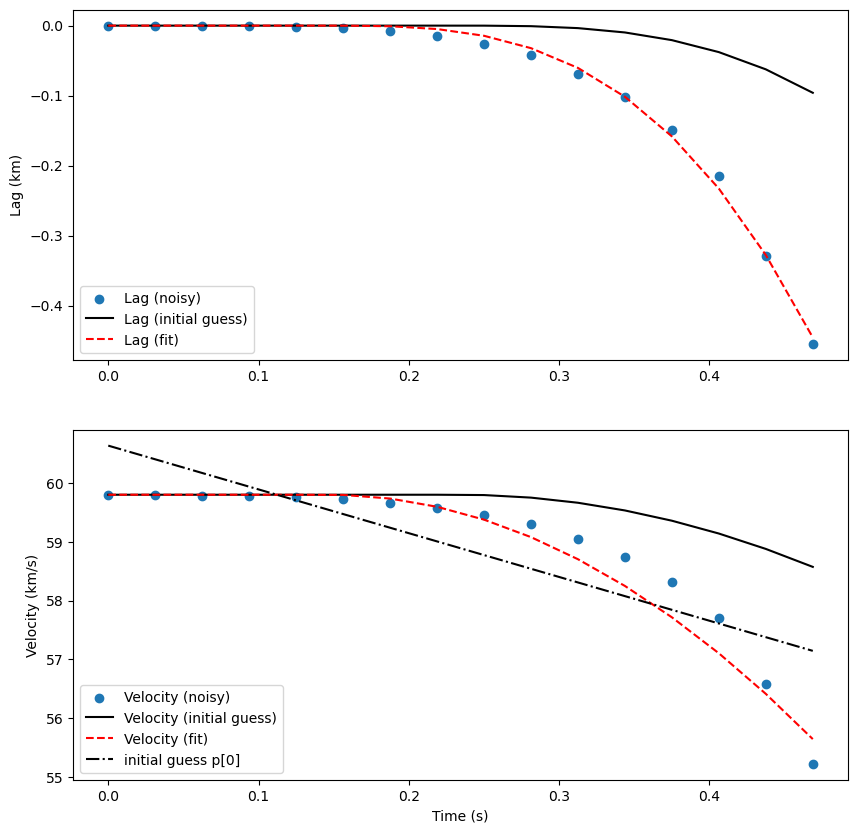

In [8]:
# read TRUEerosion_sim_v59.84_m1.33e-02g_rho0209_z39.8_abl0.014_eh117.3_er0.636_s1.61.json and get the velocity time and lenght data
with open('TRUEerosion_sim_v59.84_m1.33e-02g_rho0209_z39.8_abl0.014_eh117.3_er0.636_s1.61.json') as f:
    data = json.load(f)

    vel_sim=data['simulation_results']['leading_frag_vel_arr']#['brightest_vel_arr']#['leading_frag_vel_arr']#['main_vel_arr']
    ht_sim=data['simulation_results']['leading_frag_height_arr']#['brightest_height_arr']['leading_frag_height_arr']['main_height_arr']
    time_sim=data['simulation_results']['time_arr']#['main_time_arr']
    abs_mag_sim=data['simulation_results']['abs_magnitude']
    len_sim=data['simulation_results']['brightest_length_arr']#['brightest_length_arr']

    obs_height=data['ht_sampled']

    # # find the index of the first element of the simulation that is equal to the first element of the observation
    index_ht_sim=next(x for x, val in enumerate(ht_sim) if val <= obs_height[0])
    # find the index of the last element of the simulation that is equal to the last element of the observation
    index_ht_sim_end=next(x for x, val in enumerate(ht_sim) if val <= obs_height[-1])

    abs_mag_sim=abs_mag_sim[index_ht_sim:index_ht_sim_end]
    vel_sim=vel_sim[index_ht_sim:index_ht_sim_end]
    time_sim=time_sim[index_ht_sim:index_ht_sim_end]
    ht_sim=ht_sim[index_ht_sim:index_ht_sim_end]
    len_sim=len_sim[index_ht_sim:index_ht_sim_end]

    # divide the vel_sim by 1000 considering is a list
    time_sim = [i-time_sim[0] for i in time_sim]
    vel_sim = [i/1000 for i in vel_sim]
    len_sim = [(i-len_sim[0])/1000 for i in len_sim]
    ht_sim = [i/1000 for i in ht_sim]

    # time_sim = [i-time_sim[0] for i in time_sim]
    # len_sim = [(i-len_sim[0]) for i in len_sim]

    v0 = vel_sim[0]

    # observed data from the EMCCD ############################################################
    obs_time=data['time_sampled']
    obs_length=data['len_sampled']
    abs_mag_obs=data['mag_sampled']
    obs_vel=[v0]
    obs_length=[x/1000 for x in obs_length]
    obs_height=[x/1000 for x in obs_height]
    # append from vel_sampled the rest by the difference of the first element of obs_length divided by the first element of obs_time
    rest_vel_sampled=[(obs_length[vel_ii]-obs_length[vel_ii-1])/(obs_time[vel_ii]-obs_time[vel_ii-1]) for vel_ii in range(1,len(obs_length))]
    # append the rest_vel_sampled to vel_sampled
    obs_vel.extend(rest_vel_sampled)

    # create the lag array as the difference betyween the lenght and v0*time+len_sim[0]
    obs_lag=obs_length-(v0*np.array(obs_time)+obs_length[0])

    #### pickle file data no noise ##########################################################################

    closest_indices = find_closest_index(time_sim, obs_time)

    abs_mag_sim=[abs_mag_sim[jj_index_cut] for jj_index_cut in closest_indices]
    vel_sim=[vel_sim[jj_index_cut] for jj_index_cut in closest_indices]
    time_sim=[time_sim[jj_index_cut] for jj_index_cut in closest_indices]
    ht_sim=[ht_sim[jj_index_cut] for jj_index_cut in closest_indices]
    len_sim=[len_sim[jj_index_cut] for jj_index_cut in closest_indices]

    # create the lag array as the difference betyween the lenght and v0*time+len_sim[0]
    lag_sim=len_sim-(v0*np.array(time_sim)+len_sim[0])
    ############################################################################################################



plot_lagVel_fit(v0, np.array(obs_time), np.array(obs_lag), np.array(obs_vel), np.array(lag_sim), np.array(vel_sim))

Initial guess
[-4.399474013773199, 0.2626215306003931]
Optimal parameters
[-15.86979   0.24613]


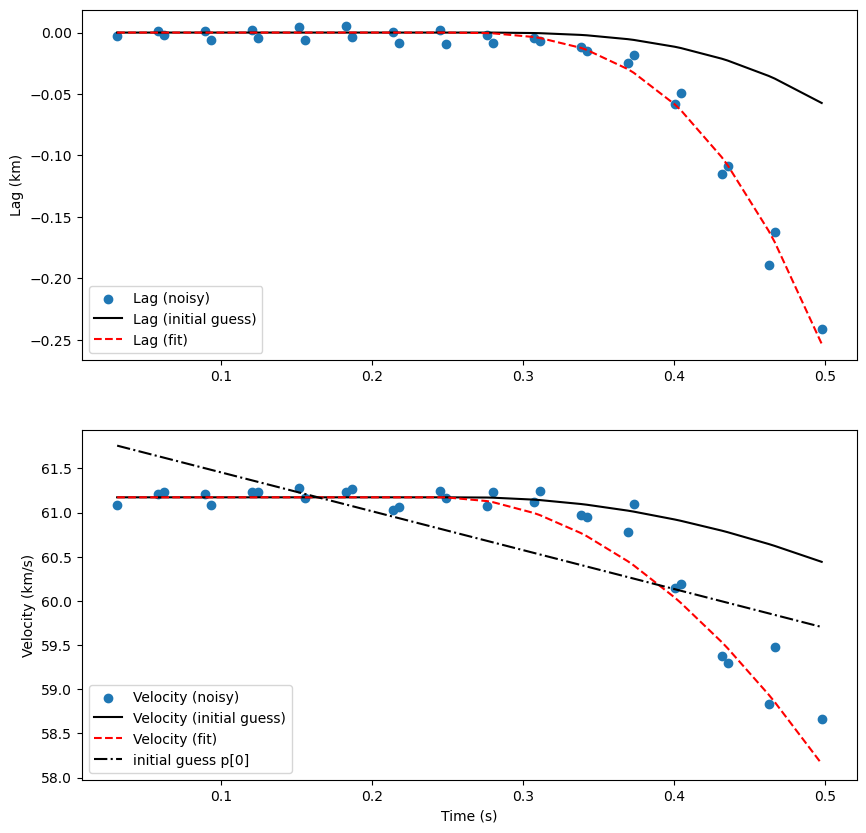

In [9]:
with open(os.path.join("/home/mvovk/WMPG-repoMAX/Code/PCA", "20210813_061452_trajectory.pickle"), 'rb') as f:
    traj = pickle.load(f, encoding='latin1')
# with open(os.path.join("/home/mvovk/WMPG-repoMAX/Code/PCA", "TRUEerosion_sim_v59.84_m1.33e-02g_rho0209_z39.8_abl0.014_eh117.3_er0.636_s1.61.pickle"), 'rb') as f:
#     traj = pickle.load(f, encoding='latin1')

vel_pickl=[]
time_pickl=[]
abs_mag_pickl=[]
height_pickl=[]
lag_pickle=[]

jj=0
for obs in traj.observations:
    jj+=1
    # first 4 observations of vel to define the v0
    if jj==1:
        elg_pickl=obs.velocities[1:int(len(obs.velocities)/4)]
        if len(elg_pickl)==0:
            elg_pickl=obs.velocities[1:2]
    elif jj==2:
        tav_pickl=obs.velocities[1:int(len(obs.velocities)/4)]
        if len(tav_pickl)==0:
            tav_pickl=obs.velocities[1:2]

    # put it at the end obs.velocities[1:] at the end of vel_pickl list
    vel_pickl.extend(obs.velocities[1:])
    time_pickl.extend(obs.time_data[1:])
    abs_mag_pickl.extend(obs.absolute_magnitudes[1:])
    height_pickl.extend(obs.model_ht[1:])
    lag_pickle.extend(obs.lag[1:])

v0 = (np.mean(elg_pickl)+np.mean(tav_pickl))/2/1000

# divide the lag and vel by 1000
vel_pickl = [i/1000 for i in vel_pickl]
lag_pickle = [i/1000 for i in lag_pickle]

# put all in the same panda dataframe
df = pd.DataFrame({'time': time_pickl, 'lag': lag_pickle, 'vel': vel_pickl})
df = df.sort_values(by='time')

plot_lagVel_fit(v0, np.array(df['time']), np.array(df['lag']), np.array(df['vel']))